[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[INFO] compiling model...
[INFO] training head...
Epoch 1/21
63/63 [==============================] - 306s 5s/step - loss: 0.7712 - accuracy: 0.4820 - val_loss: 0.6768 - val_accuracy: 0.6797
Epoch 2/21
63/63 [==============================] - 333s 5s/step - loss: 0.7073 - accuracy: 0.5240 - val_loss: 0.6134 - val_accuracy: 0.9141
Epoch 3/21
63/63 [==============================] - 327s 5s/step - loss: 0.6384 - accuracy: 0.6460 - val_loss: 0.5538 - val_accuracy: 0.9297
Epoch 4/21
63/63 [==============================] - 320s 5s/step - loss: 0.5755 - accuracy: 0.7260 - val_loss: 0.5024 - val_accuracy: 0.9375
Epoch 5/21
63/63 [==============================] - 312s 5s/step - loss: 0.5217 - accuracy: 0.7920 - val_loss: 0.4581 - val_accuracy: 0.9609
Epoch 6/21
63/63 [==============================] - 308s 5s/step - loss: 0.4812 - accuracy: 0.8320 - val_loss: 0.4149 - val_accuracy: 0.9688
Epoch 7/21
63/63 [==========================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


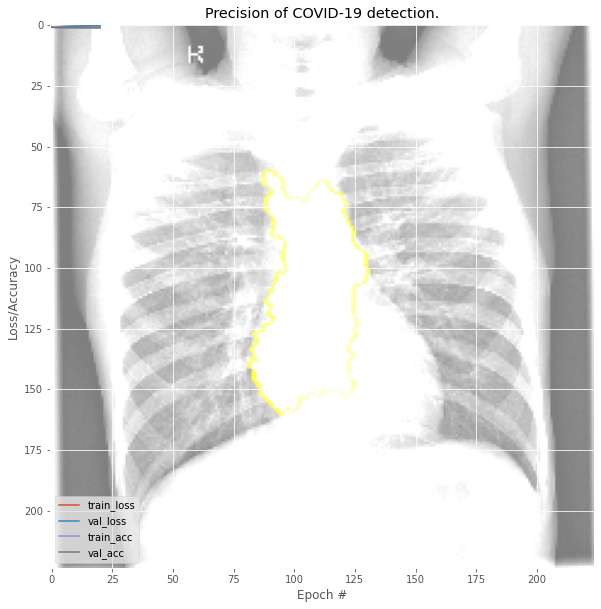

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


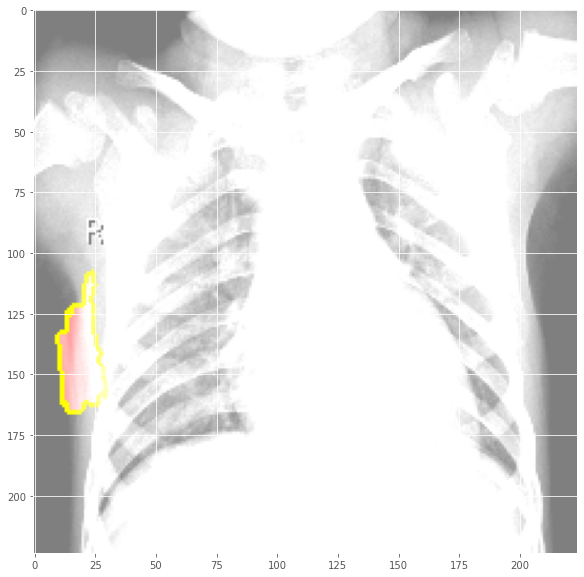

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


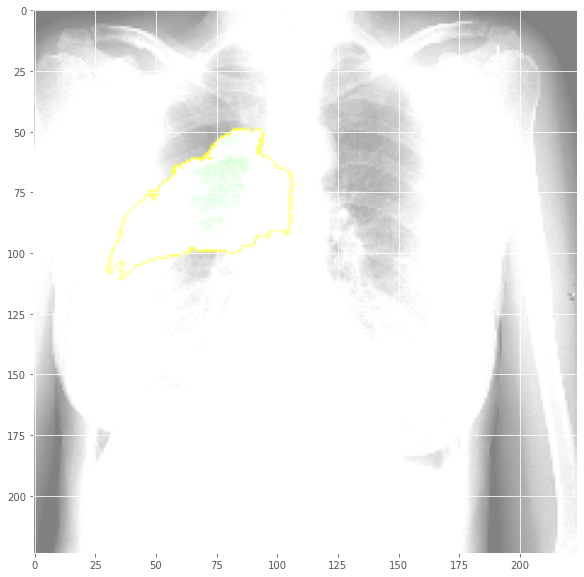

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


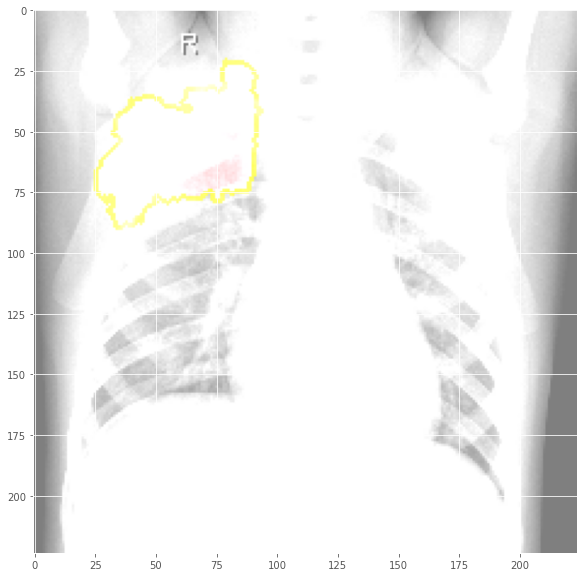

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


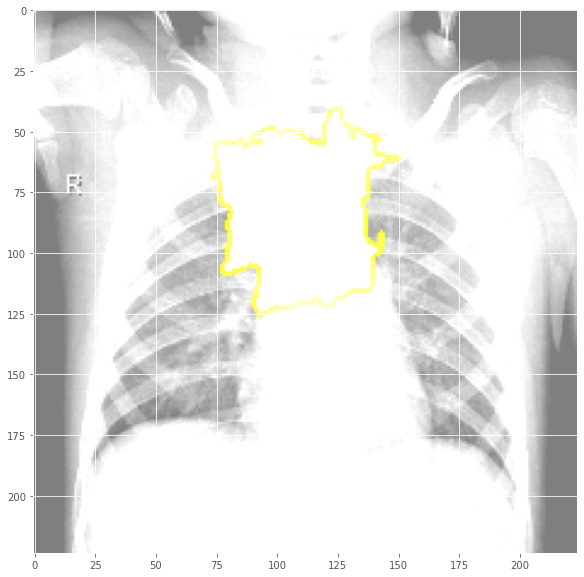

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


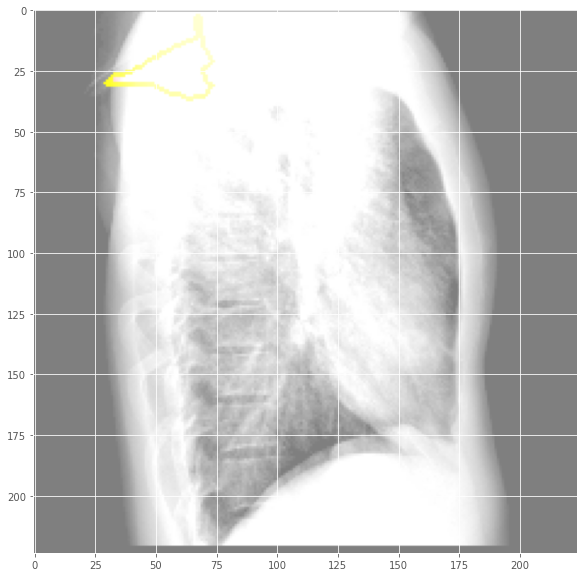

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


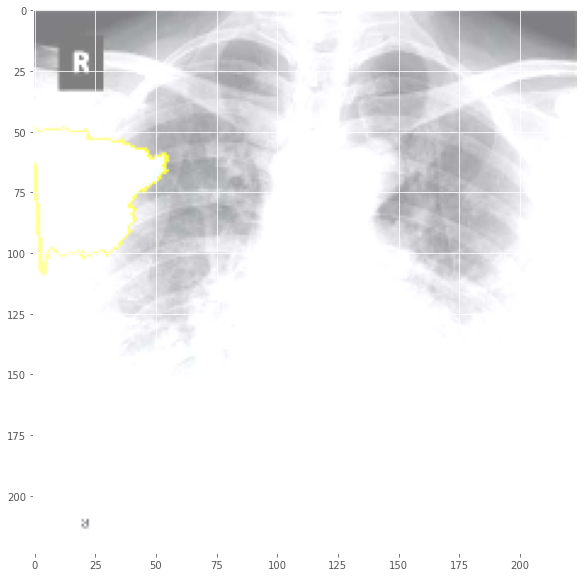

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


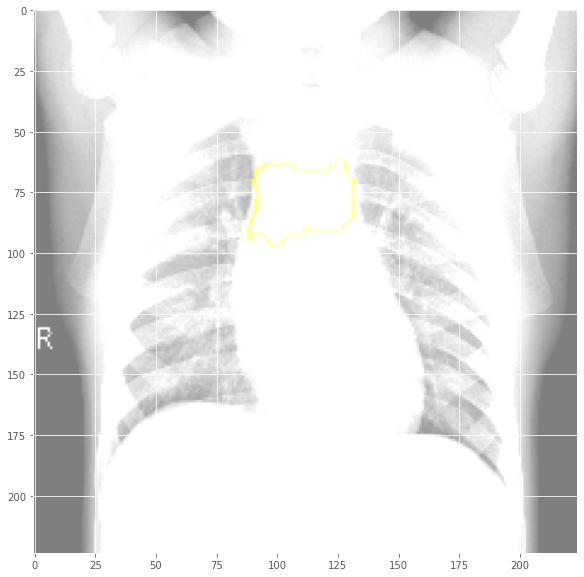

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 0 - predicted: 0


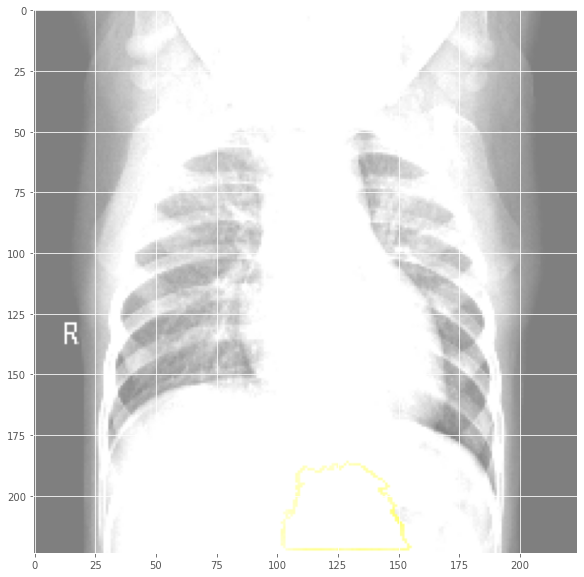

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> label: 1 - predicted: 1


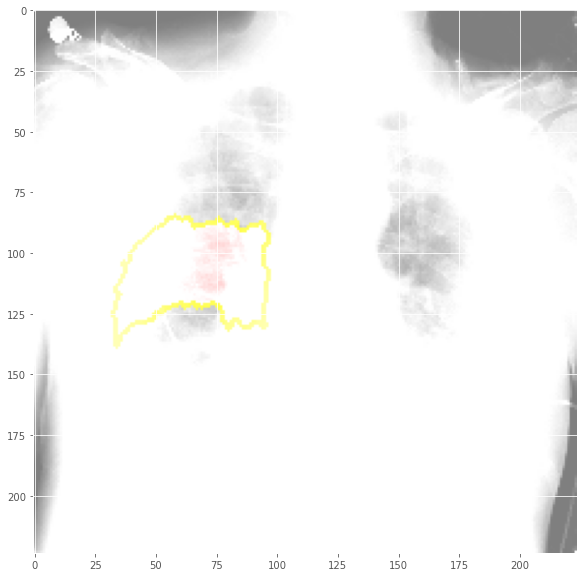

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

plt.rcParams["figure.figsize"] = (20,10)

## global params
INIT_LR = 1e-4  # learning rate
EPOCHS = 21  # training epochs
BS = 8  # batch size


## load and prepare data
imagePaths = list(paths.list_images("C:/Users/20115/Desktop/Dataset/train"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

TEST_SET_SIZE = 0.2

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels); print(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=TEST_SET_SIZE, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

## build network
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

## train
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

print("[INFO] saving COVID-19 detector model...")
model.save("covid19.model", save_format="h5")

## eval
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1) # argmax for the predicted probability
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))


## explain
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision of COVID-19 detection.")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("training_plot.png")

for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)+testX[ind])
    plt.show()

In [1]:
## explain
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Precision of COVID-19 detection.")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("training_plot.png")

for ind in range(10): 
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(testX[-ind], model.predict,
                                             hide_color=0, num_samples=42)
    print("> label:", testY[ind].argmax(), "- predicted:", predIdxs[ind])
    
    temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)+testX[ind])
    plt.show()

NameError: name 'EPOCHS' is not defined